In [ ]:
%cd /content
# !git clone https://github.com/timojl/clipseg.git #клонируем репозиторий CLIPSeg

# Commits on Sep 27, 2022
%cd /content/clipseg
# !git checkout 515ca6ec2d066d447240c1dd79f3bbbee685bd29 #восстанавливаем файлы рабочего дерева

/content
Cloning into 'clipseg'...
remote: Enumerating objects: 229, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 229 (delta 72), reused 58 (delta 58), pack-reused 140
Receiving objects: 100% (229/229), 1.40 MiB | 9.98 MiB/s, done.
Resolving deltas: 100% (125/125), done.
/content/clipseg
Note: switching to '515ca6ec2d066d447240c1dd79f3bbbee685bd29'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 515ca6e added samples for fine-grained weights

In [ ]:
# !pip install git+https://github.com/openai/CLIP.git@d50d76daa670286dd6cacf3bcd80b5e4823fc8e1 # устанавливаем CLIP и зависимости

  Cloning https://github.com/openai/CLIP.git (to revision d50d76daa670286dd6cacf3bcd80b5e4823fc8e1) to /tmp/pip-req-build-5jnl2f4w
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-5jnl2f4w
  Running command git rev-parse -q --verify 'sha^d50d76daa670286dd6cacf3bcd80b5e4823fc8e1'
  Running command git fetch -q https://github.com/openai/CLIP.git d50d76daa670286dd6cacf3bcd80b5e4823fc8e1
  Running command git checkout -q d50d76daa670286dd6cacf3bcd80b5e4823fc8e1
  Resolved https://github.com/openai/CLIP.git to commit d50d76daa670286dd6cacf3bcd80b5e4823fc8e1
  Preparing metadata (setup.py) ... done


In [ ]:
#MAIN
import torch
import requests
import cv2

! wget https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download -O weights.zip # cкачиваем и распаковываем веса CLIP
! unzip -d weights -j weights.zip
from models.clipseg import CLIPDensePredT
# repositories.clipseg.models.clipseg
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

# загрузка модели в переменную
model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
model.eval(); #инициализация модели, команда выполнения строки как части кода

# используем веса декодера, а не веса CLIP, параметр strict=False при использовании предварительно обученной модели
model.load_state_dict(torch.load('weights/rd64-uni.pth', map_location=torch.device('cpu')), strict=False);

--2023-09-25 10:18:52--  https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download
Resolving owncloud.gwdg.de (owncloud.gwdg.de)... 134.76.23.45
Connecting to owncloud.gwdg.de (owncloud.gwdg.de)|134.76.23.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘weights.zip’

weights.zip             [      <=>           ]   9.68M  8.09MB/s    in 1.2s    

2023-09-25 10:18:53 (8.09 MB/s) - ‘weights.zip’ saved [10146905]

Archive:  weights.zip
 extracting: weights/rd16-uni.pth    
 extracting: weights/rd64-uni-refined.pth  
 extracting: weights/rd64-uni.pth    


100%|███████████████████████████████████████| 335M/335M [00:06<00:00, 51.2MiB/s]


In [ ]:
# !pip install imantics

  Preparing metadata (setup.py) ... done
  Created wheel for imantics: filename=imantics-0.1.12-py3-none-any.whl size=16010 sha256=f62a9eda2823d0bd1e669806cc071b321d77d8a9bd31a5d4359160149f352f4d
  Stored in directory: /root/.cache/pip/wheels/56/6a/be/4c60e88b14abec4e93234a1f7f91ce8abe1ae88a2b3eaad3ac
Successfully built imantics


In [ ]:
import numpy as np
from numpy import asarray
import skimage
from imantics import Polygons, Mask
from google.colab.patches import cv2_imshow
import skimage.morphology
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from skimage import io
from skimage.filters import gaussian
from skimage.segmentation import active_contour

In [ ]:
#MAIN
# input_image = Image.open('/content/1.jpg') #загружаем изображение через функцию PIL
input_image = Image.open('/content/ad000014.png')
print(type(input_image))
# <class 'numpy.ndarray'>

print(input_image.size)
print(type(input_image.size))
# (400, 225)
# <class 'tuple'>

#получаем размеры входящего изображения
w, h = input_image.size # ширина и высота
print('width: ', w)
print('height:', h)

# или подгружаем по URL
# image_url = 'https://farm5.staticflickr.com/4141/4856248695_03475782dc_z.jpg'
# input_image = Image.open(requests.get(image_url, stream=True).raw)

#задаем конфигурацию преобразований входящего изображения в мат.объект - тензор
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((352, 352)),
])
# применяем конфигурацию к входящему изображению
img = transform(input_image).unsqueeze(0) # создаем 3D тензор

<class 'PIL.PngImagePlugin.PngImageFile'>
(952, 1158)
<class 'tuple'>
width:  952
height: 1158


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


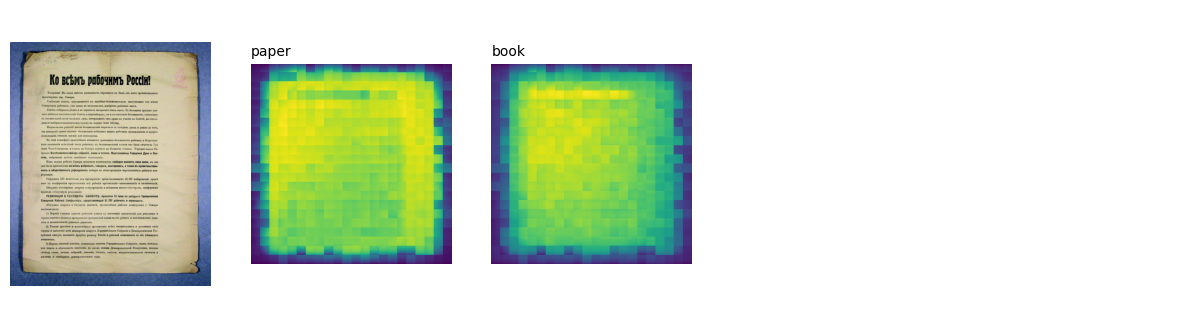

In [ ]:
#MAIN
# обозначаем входящие подсказки
prompts = ['paper', 'book'] #1/2 index of mask
num_of_p = len(prompts)

# предсказание области по подсказкам
with torch.no_grad():
    preds = model(img.repeat(num_of_p,1,1,1), prompts)[0]

# визуализация предсказания
_, ax = plt.subplots(1, 5, figsize=(15, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(input_image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(num_of_p)];
[ax[i+1].text(0, -15, prompts[i]) for i in range(num_of_p)];

In [ ]:
print(preds)

tensor([[[[-4.2458, -4.2445, -4.2141,  ..., -3.9139, -3.9436, -3.9621],
          [-4.1471, -4.1403, -4.1146,  ..., -3.8276, -3.8515, -3.8731],
          [-3.9321, -3.9127, -3.8912,  ..., -3.6640, -3.6916, -3.7120],
          ...,
          [-2.9551, -2.9521, -2.9258,  ..., -3.9668, -3.9886, -4.0138],
          [-3.0984, -3.0966, -3.0741,  ..., -4.0773, -4.1011, -4.1262],
          [-3.2578, -3.2464, -3.2311,  ..., -4.1962, -4.2210, -4.2518]]],


        [[[-4.8114, -4.8119, -4.7802,  ..., -5.0743, -5.1009, -5.1158],
          [-4.7054, -4.7016, -4.6751,  ..., -4.9905, -5.0112, -5.0304],
          [-4.4808, -4.4626, -4.4420,  ..., -4.8391, -4.8594, -4.8759],
          ...,
          [-3.3595, -3.3575, -3.3301,  ..., -3.9248, -3.9463, -3.9699],
          [-3.5028, -3.5028, -3.4792,  ..., -4.0273, -4.0486, -4.0738],
          [-3.6633, -3.6528, -3.6359,  ..., -4.1364, -4.1603, -4.1880]]]])


In [ ]:
#MAIN
threshold = 0.4 # порог вероятности тепловой карты сегментации

# сигмоидальная функция поэлементно сжимает значения в диапазоне от 0 до 1
flat_preds = torch.sigmoid(preds.squeeze()).reshape((preds.shape[0], -1))

# Инициализируем маску объекта с заданным порогом вероятности
flat_preds_with_treshold = torch.full((preds.shape[0] + 1, flat_preds.shape[-1]), threshold) #заполнение тензора значениями
flat_preds_with_treshold[1:preds.shape[0]+1,:] = flat_preds

# Возвращает индексы наибольших элементов в тензоре
inds = torch.topk(flat_preds_with_treshold, 1, dim=0).indices.reshape((preds.shape[-2], preds.shape[-1]))

In [ ]:
print(inds)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


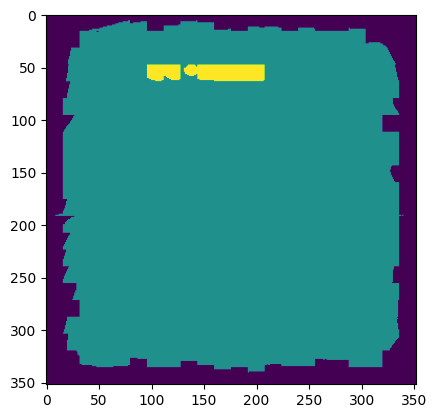

In [ ]:
plt.imshow(inds)
#352 x 352 image size
# маска в CLIPSeg (сжатая)

In [ ]:
#MAIN
import numpy as np

inds_np = inds.numpy().astype(np.uint32)
# изображение маски сегментации переводим в формат numpy
unique_inds = np.unique(inds_np).tolist()
# уникальные значения внутри маски

In [ ]:
print(inds_np)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# коэффициент сжатия изображения в CLIPSeg
step1 = w/352
step2 = h/352
print(step1)
print(step2)

2.7443181818181817
3.6363636363636362


In [ ]:
# Изменение маски согласно размерам исходного изображения
mask_resize = cv2.resize(inds_np.astype(np.uint8), (w,h), interpolation=cv2.INTER_NEAREST)

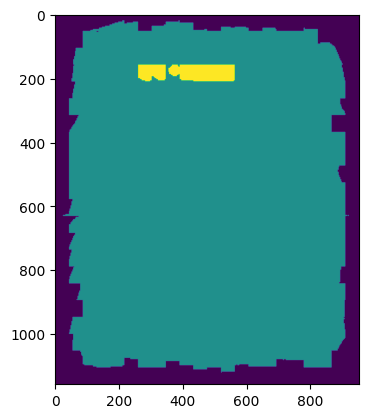

In [ ]:
# маска исходного изображения
plt.imshow(mask_resize)

https://pytorch.org/vision/stable/generated/torchvision.utils.draw_segmentation_masks.html

In [ ]:
# !pip3 install opencv-contrib-python

https://github.com/jsbroks/imantics

Документация
https://imantics.readthedocs.io/en/latest/api.html#mask-object

In [ ]:
print(inds_np)
for mask in inds_np:
  print(mask)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 

In [ ]:
#MAIN
# ПОЛУЧЕНИЕ КООРДИНАТ КОНТУРОВ МАСКИ, соответствующих размеру исходного изображения
polygons = Mask(mask_resize).polygons()
  # print(polygons)
point_array = polygons.points # list с numpy_arrays внутри формата [x1, y1], [x2, y2] ... сущностная сегментация
print(type(point_array))
segment_array = polygons.segmentation
print(type(segment_array)) #list формата [x1, y1, x2, y2 ...] семантическая сегментация

<class 'list'>
<class 'list'>


In [ ]:
#MAIN
#распаковка результатов сущностной сегментации в массив numpy
contours_array = []
for contours in point_array:
  # print(contours)
  for contour in contours:
    # print(contour)
    contours_array.append(contour.reshape(-1,2))

contours_array = np.array(contours_array) #получаем координаты контура книги с порогом вероятности 0.4

In [ ]:
print(contours_array)

[[[917 629]]

 [[917 631]]

 [[919 631]]

 ...

 [[217  30]]

 [[216  29]]

 [[216  20]]]


In [ ]:
from numpy import asarray
from google.colab.patches import cv2_imshow

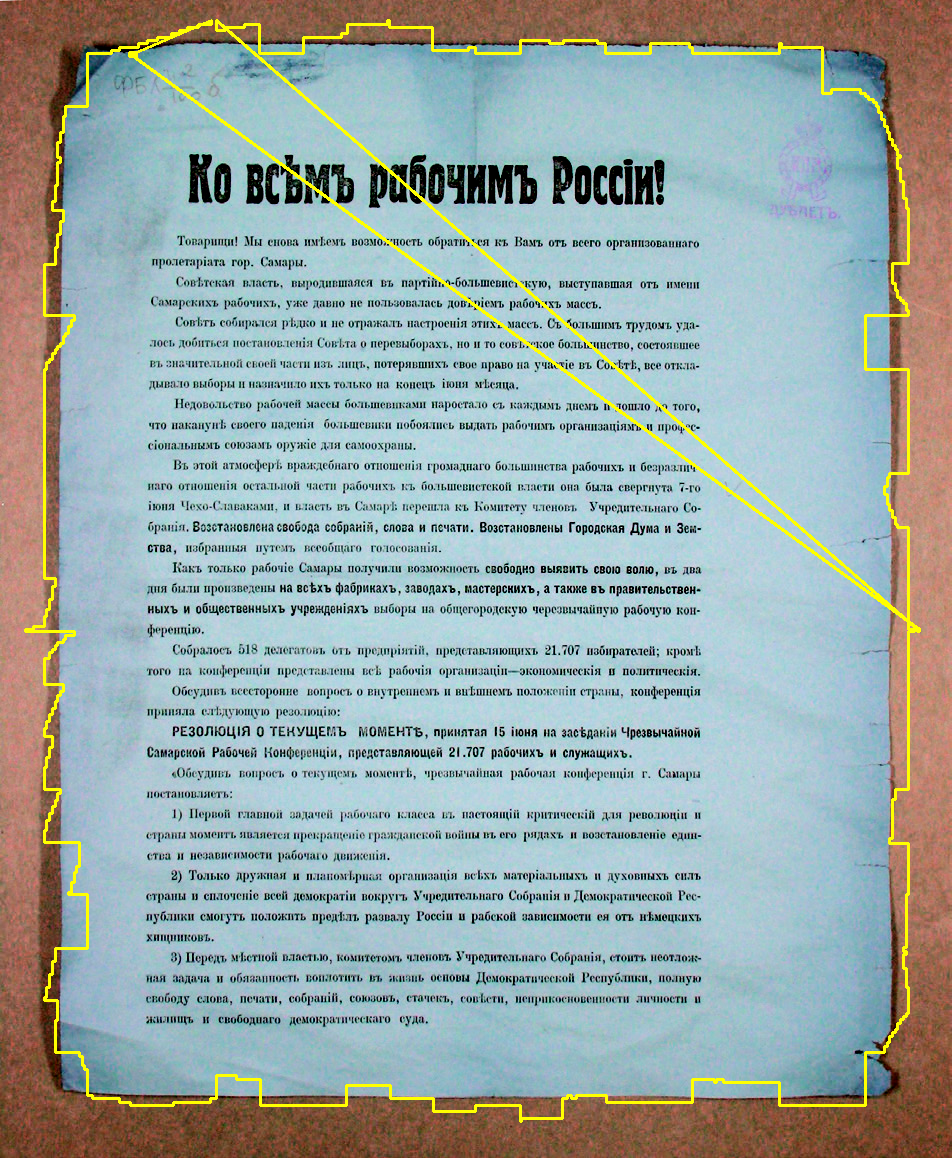

In [ ]:
# Create a black image
image2 = input_image.copy() #создаем копию входящего изображения

# image2 = np.zeros((512,512,3), np.uint8)
numpyimg = asarray(image2) #переводим изображение в массив numpy

# Coordinates of the contour - переменная contours_array

# Отрисовка внешних контуров
cv2.polylines(numpyimg,[contours_array],True,(0,255,255),2)

# Рисуем заполненный контур
# cv2.fillConvexPoly(numpyimg, contours_array, (255,0,0), cv2.LINE_AA)


# Вывод изображения, проверка
cv2_imshow(numpyimg)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
# MAIN Создаем нужную форму массива изображения
# Print shape
print(numpyimg.shape)
# (1280, 966, 3)
# Reshape
numpy_array = numpyimg.reshape((-1,2))
# Print new shape
print(numpy_array.shape)
# (1854720, 2)
print(numpy_array)
# [[ 73 105]
#  [126  77]
#  [109 130]
#  ...
#  [  0   2]
#  [  0   0]
#  [  1   0]]

(1158, 952, 3)
(1653624, 2)
[[217 208]
 [237 211]
 [207 232]
 ...
 [ 28  67]
 [110  32]
 [ 69 111]]


In [ ]:
# Индекс наиболее вероятной области интереса в CLIP
# seg_value = 2
seg_value = 1

# на вход подается маска сегмента в бинарном варианте (с измененным размером изображения)
if mask_resize is not None:
    np_seg = np.array(mask_resize)
    # print(np_seg)
    segmentation = np.where(np_seg == seg_value)

  # Получаем координаты рамки объекта Bounding Box
    bbox = 0, 0, 0, 0
    if len(segmentation) != 0 and len(segmentation[1]) != 0 and len(segmentation[0]) != 0:
        x_min = int(np.min(segmentation[1]))
        x_max = int(np.max(segmentation[1]))
        y_min = int(np.min(segmentation[0]))
        y_max = int(np.max(segmentation[0]))

        bbox = x_min, x_max, y_min, y_max

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# проверка
print(bbox)

(25, 919, 20, 1121)


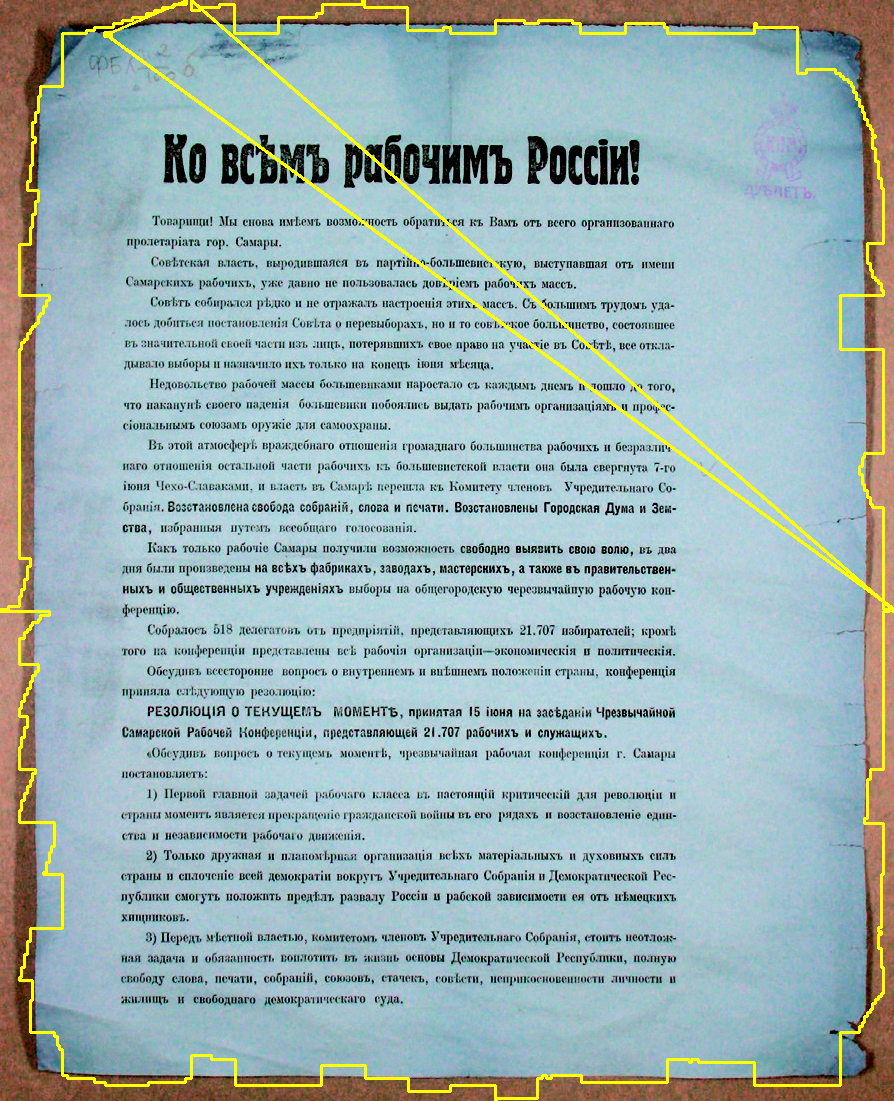

In [ ]:
#  создание обрезанного изображения с книгой/разворотом
crop = numpyimg[y_min:y_max, x_min:x_max]
# вывод обрезанного изображения
cv2_imshow(crop)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
# перевод вырезанного изображения в RGB
crop_image = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)

In [ ]:
# ДОПОЛНИТЕЛЬНО
# визуализация точек сегментации книги
# image2 = input_image.copy()
# numpyimg = asarray(image2) #изображение numpy
# cv2.drawContours(numpyimg, contours_array, -1, (0, 255, 0), 3, cv2.CHAIN_APPROX_NONE)

# cv2_imshow(numpyimg)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
cv2.imwrite("sample.png", crop_image)

True